In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install face_recognition
!pip3 install retina-face
!git clone https://github.com/peteryuX/retinaface-tf2.git
%cd retinaface-tf2/
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=0936b83b971c12513e81560cb1a7f63b8af030665cf78b7ef124be86241643d8
  Stored in directory: /root/.cache/pip/wheels/22/a8/60/4a2aeb763d63f50190f4c4e07069a22245347eeafdb3a67551
Successfully built face-recognition-models
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'retinaface-tf2'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 125 (delta 34), reused 31 (delta 31), pack-reused 77
Receiving objects: 100% (125/125), 1.32 MiB | 1.29 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/

In [ ]:
!pip install keras_applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
#image and data packages
from time import time
import face_recognition
import cv2
from PIL import Image
from skimage import color
from skimage.color import rgb2gray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.datasets import fetch_lfw_people
import os
import dlib
from skimage import exposure
from google.colab.patches import cv2_imshow
from retinaface import RetinaFace

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


#preprocessing
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV

# Function Declarations #

In [ ]:
def extract_name(path):
    if 'george' in path:
      return 'George W Bush'
    elif 'ariel' in path:
      return 'Ariel Sharon'
    elif 'colin' in path:
      return 'Colin Powell'
    elif 'donald' in path:
      return 'Donald Rumsfield'
    elif 'gerard' in path:
      return 'Gerhard Schroder'
    elif 'hugo' in path:
      return 'Hugo Chavez'  
    elif 'tony' in path:
      return 'Tony Blair' 
    else:
      return 'other'
def predict_my_photo(photo_path):
    # Load the image 
    my_image = face_recognition.load_image_file(photo_path)

    # Resize the image
    my_image_resized = cv2.resize(my_image, (w, h))

    # Convert the image to grayscale
    my_image_gray = cv2.cvtColor(my_image_resized, cv2.COLOR_BGR2GRAY)
    my_image_flattened = my_image_gray.flatten()

    # Preprocess the image: Standard scaling and PCA transformation
    my_image_scaled = scaler.transform([my_image_flattened])
    my_image_pca = pca.transform(my_image_scaled)

    # Use the model to make a prediction
    my_prediction = min_diff(my_image_pca, X_train_pca, y_train)

    # Create a custom title for your photo
    my_photo_title = "predicted: %s" % target_names[my_prediction[0]]

    # Load the photo as a grayscale image
    my_photo = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)
    my_photo_resized = cv2.resize(my_photo, (w, h))

    plot_gallery([my_photo_resized], [my_photo_title], h, w)


'''def predict_a_photo(photo_path):
    # for use with predict_all_photos

    # Load the image
    my_image = face_recognition.load_image_file(photo_path)

    # Apply image sharpening
    sharpening_kernel = np.array([[-1, -2, -1],[-2,  17, -2],[-1, -2, -1]])
    my_image = cv2.filter2D(my_image, -1, sharpening_kernel)

    # Resize the image
    my_image_resized = cv2.resize(my_image, (w, h))

    # Convert the image to grayscale
    my_image_gray = cv2.cvtColor(my_image_resized, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    my_image_gray = cv2.equalizeHist(my_image_gray)

    my_image_flattened = my_image_gray.flatten()

    # Preprocess the image: Standard scaling and PCA transformation
    my_image_scaled = scaler.transform([my_image_flattened])
    my_image_pca = pca.transform(my_image_scaled)

    # Use the model to make a prediction
    my_prediction = min_diff(my_image_pca, X_train_pca, y_train)

    # Create custom titles for your photo
    my_photo_title_predicted = "predicted:"
    my_photo_title_target = "{}".format(target_names[my_prediction[0]])
    my_photo_title = "{}\n{}".format(my_photo_title_predicted, my_photo_title_target)

    # Load the photo as a grayscale image
    my_photo = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)
    my_photo_resized = cv2.resize(my_photo, (w, h))

    return my_photo_resized, my_photo_title'''


def predict_a_photo_detect(photo_path):
    # for use with predict_all_photos
    true_label = extract_name(photo_path)

    # Load image
    my_image = cv2.imread(photo_path)


    # Detect face
    ext_faces = RetinaFace.extract_faces(my_image, align=True)
    if len(ext_faces) == 0:
        print("No faces detected in image: {}".format(photo_path))
        return None
    elif len(ext_faces) == 1:
        # Only one face detected, use it
        my_image_resized = cv2.resize(ext_faces[0], (w, h))
    else:
        # Multiple faces detected, select the largest face
        faces = sorted(ext_faces, key=lambda x: x.shape[0]*x.shape[1], reverse=True)
        my_image_resized = cv2.resize(faces[0], (w, h))

    # Resize cropped image to desired dimensions
    my_image_resized = cv2.resize(my_image_resized, (w, h))

    # Convert the image to grayscale
    my_image_gray = cv2.cvtColor(my_image_resized, cv2.COLOR_RGB2BGR)
    my_image_gray = cv2.cvtColor(my_image_gray, cv2.COLOR_BGR2GRAY)

    
    my_image_filtered = cv2.bilateralFilter(my_image_gray, 5, 75, 75)



    # Apply histogram equalization
    my_image_gray = cv2.equalizeHist(my_image_filtered)

    # Flatten the image
    my_image_flattened = my_image_gray.flatten()

    # Preprocess the image: Standard scaling and PCA transformation
    my_image_scaled = scaler.transform([my_image_flattened])
    my_image_pca = pca.transform(my_image_scaled)

    # Use the model to make a prediction
    my_prediction = min_diff(my_image_pca, X_pca, y)

    # Create custom titles for your photo
    my_photo_title_target = "predicted: {}".format(target_names[my_prediction[0]])
    my_photo_title_true = "true: {}".format(true_label)
    my_photo_title = "{}\n{}".format(my_photo_title_target, my_photo_title_true)

    # Load the photo as a grayscale image
    my_photo = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)

    return my_image_gray, my_photo_title, true_label, target_names[my_prediction[0]]




'''def predict_a_photo_detect(photo_path):
    # for use with predict_all_photos
    true_label = extract_name(photo_path)

    #Load image
    my_image = face_recognition.load_image_file(photo_path)
    

    #detect face
    face = face_recognition.face_locations(my_image)[0]
    center = (face[3]*face[1])//2, (face[0]+face[2])//2
    left = center[0] - w//2
    upper = center[1] + h//2
    right = center[0] + w//2
    lower = center[1] - h//2

    #crop image
    im = Image.open(photo_path)
    im_cropped = im.crop((face[3], face[0], face[1], face[2])) #left, upper, right, and lower
    im_np = np.asarray(im_cropped)

    # Resize the image
    my_image_resized = cv2.resize(im_np, (w, h))

    # Convert the image to grayscale
    my_image_gray = cv2.cvtColor(my_image_resized, cv2.COLOR_BGR2GRAY)

    my_image_flattened = my_image_gray.flatten()

    # Preprocess the image: Standard scaling and PCA transformation
    my_image_scaled = scaler.transform([my_image_flattened])
    my_image_pca = pca.transform(my_image_scaled)

    # Use the model to make a prediction
    my_prediction = min_diff(my_image_pca, X_pca, y)

    # Create custom titles for your photo
    my_photo_title_target = "predicted: {}".format(target_names[my_prediction[0]])
    my_photo_title_true = "true: {}".format(true_label)
    my_photo_title = "{}\n{}".format(my_photo_title_target, my_photo_title_true)

    return my_image_gray, my_photo_title, true_label, target_names[my_prediction[0]]'''

'''def predict_a_photo_detect(photo_path):
    # for use with predict_all_photos
    true_label = extract_name(photo_path)

    # Load image
    my_image = face_recognition.load_image_file(photo_path)

    # detect face
    face_location = face_recognition.face_locations(my_image)[0]
    top, right, bottom, left = face_location

    # crop image
    im = Image.open(photo_path)
    im_cropped = im.crop((left, top, right, bottom))
    im_np = np.asarray(im_cropped)

    # Resize the image
    my_image_resized = cv2.resize(im_np, (w, h))

    # Convert the image to grayscale
    my_image_gray = cv2.cvtColor(my_image_resized, cv2.COLOR_BGR2GRAY)
    my_image_filtered = cv2.bilateralFilter(my_image_gray, 5, 75, 75)



    # Apply histogram equalization
    #my_image_gray = cv2.equalizeHist(my_image_gray)

    my_image_flattened = my_image_filtered.flatten()

    # Preprocess the image: Standard scaling and PCA transformation
    my_image_scaled = scaler.transform([my_image_flattened])
    my_image_pca = pca.transform(my_image_scaled)

    # Use the model to make a prediction
    my_prediction = min_diff(my_image_pca, X_pca, y)

    # Create custom titles for your photo
    my_photo_title_target = "predicted: {}".format(target_names[my_prediction[0]])
    my_photo_title_true = "true: {}".format(true_label)
    my_photo_title = "{}\n{}".format(my_photo_title_target, my_photo_title_true)


    return my_image_gray, my_photo_title, true_label, target_names[my_prediction[0]]'''






def ml_predict_a_photo_detect(photo_path, model):
    # for use with predict_all_photos
    true_label = extract_name(photo_path)

    # Load image
    my_image = cv2.imread(photo_path)


    # Detect face
    ext_faces = RetinaFace.extract_faces(my_image, align=True)
    if len(ext_faces) == 0:
        print("No faces detected in image: {}".format(photo_path))
        return None
    elif len(ext_faces) == 1:
        # Only one face detected, use it
        my_image_resized = cv2.resize(ext_faces[0], (w, h))
    else:
        # Multiple faces detected, select the largest face
        faces = sorted(ext_faces, key=lambda x: x.shape[0]*x.shape[1], reverse=True)
        my_image_resized = cv2.resize(faces[0], (w, h))

    # Resize cropped image to desired dimensions
    my_image_resized = cv2.resize(my_image_resized, (w, h))

    # Convert the image to grayscale
    my_image_gray = cv2.cvtColor(my_image_resized, cv2.COLOR_RGB2BGR)
    my_image_gray = cv2.cvtColor(my_image_gray, cv2.COLOR_BGR2GRAY)

    
    my_image_filtered = cv2.bilateralFilter(my_image_gray, 5, 75, 75)



    # Apply histogram equalization
    my_image_gray = cv2.equalizeHist(my_image_filtered)

    # Flatten the image
    my_image_flattened = my_image_gray.flatten()

    # Preprocess the image: Standard scaling and PCA transformation
    my_image_scaled = scaler.transform([my_image_flattened])
    my_image_pca = pca.transform(my_image_scaled)

    # Use the model to make a prediction
    prediction = model.predict(my_image_pca)
    my_prediction = target_names[prediction][0]
    # Create custom titles for your photo
    my_photo_title_target = "predicted: {}".format(my_prediction)
    my_photo_title_true = "true: {}".format(true_label)
    my_photo_title = "{}\n{}".format(my_photo_title_target, my_photo_title_true)

    # Load the photo as a grayscale image
    my_photo = cv2.imread(photo_path, cv2.IMREAD_GRAYSCALE)

    return my_image_pca[0], my_image_gray, my_photo_title, true_label, my_prediction, prediction


In [ ]:
def predict_all_photos(folder_path):
    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    # Filter the list to include only image files (e.g., .jpg, .png)
    image_extensions = ['.jpg', '.jpeg', '.png']
    image_files = [file for file in file_list if any(file.lower().endswith(ext) for ext in image_extensions)]


    #initialize photos and predictions
    photos = []
    titles = []
    predictions = []
    labels = []
    # Process each image file using the predict_my_photo function
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        print(f"Processing {image_file}:")
        photo, title, label, pred = predict_a_photo_detect(image_path)
        photos.append(photo)
        titles.append(title)
        predictions.append(pred)
        labels.append(label)
    print('accuracy: ', accuracy_score(labels, predictions))
    plot_gallery_new(photos, titles, h, w)
    plt.tight_layout()


def ml_predict_all_photos(folder_path, model):
    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    # Filter the list to include only image files (e.g., .jpg, .png)
    image_extensions = ['.jpg', '.jpeg', '.png']
    image_files = [file for file in file_list if any(file.lower().endswith(ext) for ext in image_extensions)]


    #initialize photos and predictions
    photos = []
    titles = []
    predictions = []
    labels = []
    X = []
    pred_tracks = []
    # Process each image file using the predict_my_photo function
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        print(f"Processing {image_file}:")
        row, photo, title, label, pred, tracked = ml_predict_a_photo_detect(image_path, model)
        photos.append(photo)
        titles.append(title)
        predictions.append(pred)
        labels.append(label)
        X.append(row)
        pred_tracks.append(tracked)
    print('accuracy: ', accuracy_score(labels, predictions))
    plot_gallery_new(photos, titles, h, w)
    plt.tight_layout()

    return X, labels, predictions, pred_tracks


def plot_gallery_new(images, titles, h, w, n_row =5, n_col=5):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.6)
    
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        resized_image = resize(images[i], (h, w), anti_aliasing=True)
        plt.imshow(resized_image, cmap=plt.cm.gray)
        plt.title(titles[i], size=8)
        plt.xticks(())
        plt.yticks(())


In [ ]:
def min_diff(input, data, y):
  #predicted values
  predicted = []

  #for each input
  for inp in input:
    min_dist = 1000000000

    #check distance from input to each row in known faces
    for i, row in enumerate(data):
    
      dist = math.dist(inp, row)

      if dist < min_dist:
        min_dist = dist
        min_idx = i
    
    predicted.append(y[min_idx])
  return predicted


def plot_gallery(images, titles, h, w, n_row=7, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)



# Getting Data and Preprocessing #

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.6)



In [ ]:
n_samples, h, w = lfw_people.images.shape
#n_features = X.shape[1]  

X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = len(target_names)


print("Total dataset size:")
print("n_samples: %d" % n_samples)
#print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("height: %d" % h)
print("width: %d" % w)



Total dataset size:
n_samples: 1288
n_classes: 7
height: 75
width: 56


In [ ]:
lfw_people.images.shape

(1288, 75, 56)

In [ ]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

(1288, 4200)


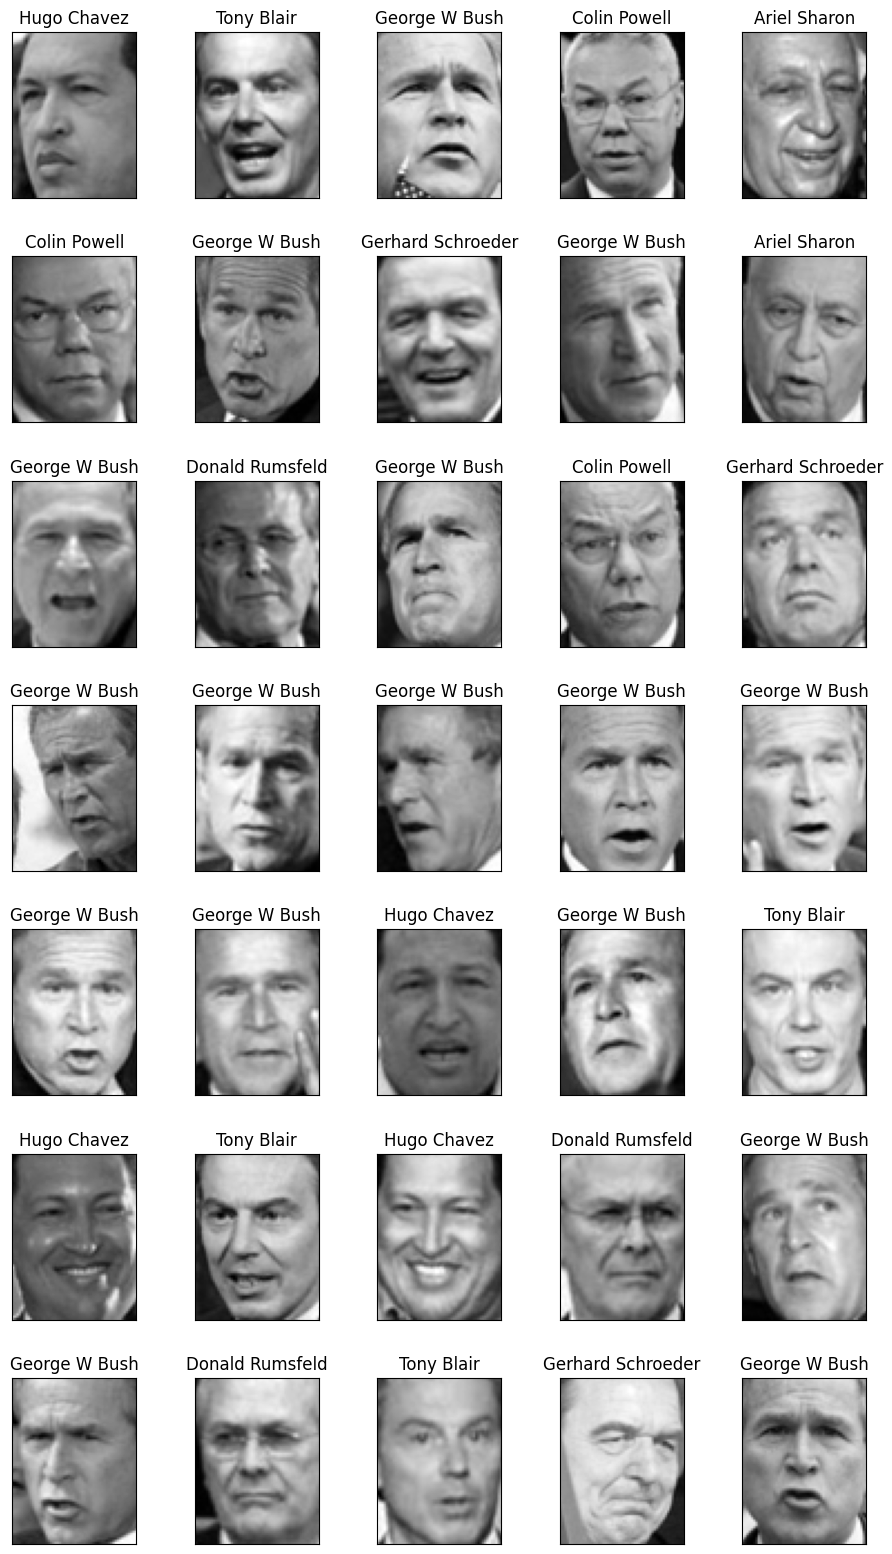

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)


#plot data
print(X.shape)
train_labels = [target_names[y] for y in y]
plot_gallery(X, train_labels, h, w)

# Eigenfaces #

In [ ]:
n_components = 38
scaler = StandardScaler()
scaler_tts = StandardScaler()
X_train_std = scaler_tts.fit_transform(X_train)
X_std = scaler.fit_transform(X)
X_test_std = scaler_tts.transform(X_test)
print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_std)
pca_tts = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train_std)

print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_pca = pca.transform(X_std)
X_train_pca = pca_tts.transform(X_train_std)
X_test_pca = pca_tts.transform(X_test_std)
print("done in %0.3fs" % (time() - t0))

Extracting the top 38 eigenfaces from 1288 faces
done in 1.800s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.087s


In [ ]:
eigenfaces[0].shape

(75, 56)

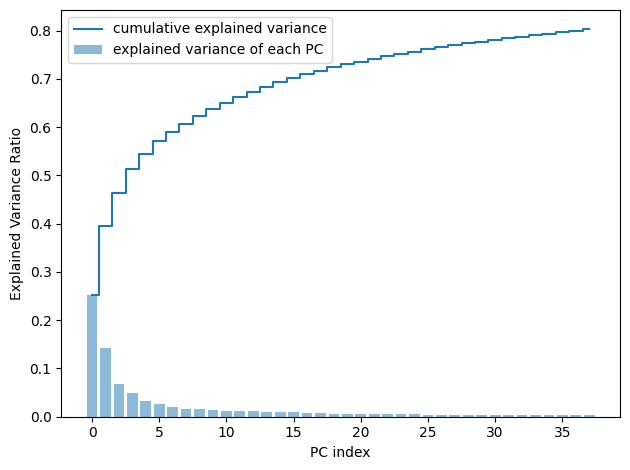

In [ ]:
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='explained variance of each PC')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('PC index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
exp_var_pca[0:38]

array([0.2527516 , 0.1427463 , 0.06802466, 0.04935954, 0.03181669,
       0.02601474, 0.01971159, 0.01668381, 0.01552634, 0.01495288,
       0.01267726, 0.01215445, 0.01101035, 0.00988865, 0.00931943,
       0.00896589, 0.00833229, 0.00723957, 0.00647174, 0.00611929,
       0.0060108 , 0.00550991, 0.00513311, 0.00503756, 0.00486278,
       0.00458675, 0.00432913, 0.00414115, 0.00395247, 0.00366621,
       0.00346525, 0.0034313 , 0.0033282 , 0.00324056, 0.00313492,
       0.00309525, 0.00298009, 0.00274295], dtype=float32)

In [ ]:
cum_sum_eigenvalues[0:38]

array([0.2527516 , 0.3954979 , 0.46352255, 0.5128821 , 0.5446988 ,
       0.5707135 , 0.59042513, 0.60710895, 0.6226353 , 0.6375882 ,
       0.65026546, 0.6624199 , 0.67343026, 0.6833189 , 0.69263834,
       0.70160425, 0.70993656, 0.71717614, 0.7236479 , 0.7297672 ,
       0.73577803, 0.74128795, 0.74642104, 0.7514586 , 0.7563214 ,
       0.7609081 , 0.7652373 , 0.7693784 , 0.77333087, 0.7769971 ,
       0.7804623 , 0.78389364, 0.78722185, 0.79046243, 0.79359734,
       0.7966926 , 0.7996727 , 0.80241567], dtype=float32)

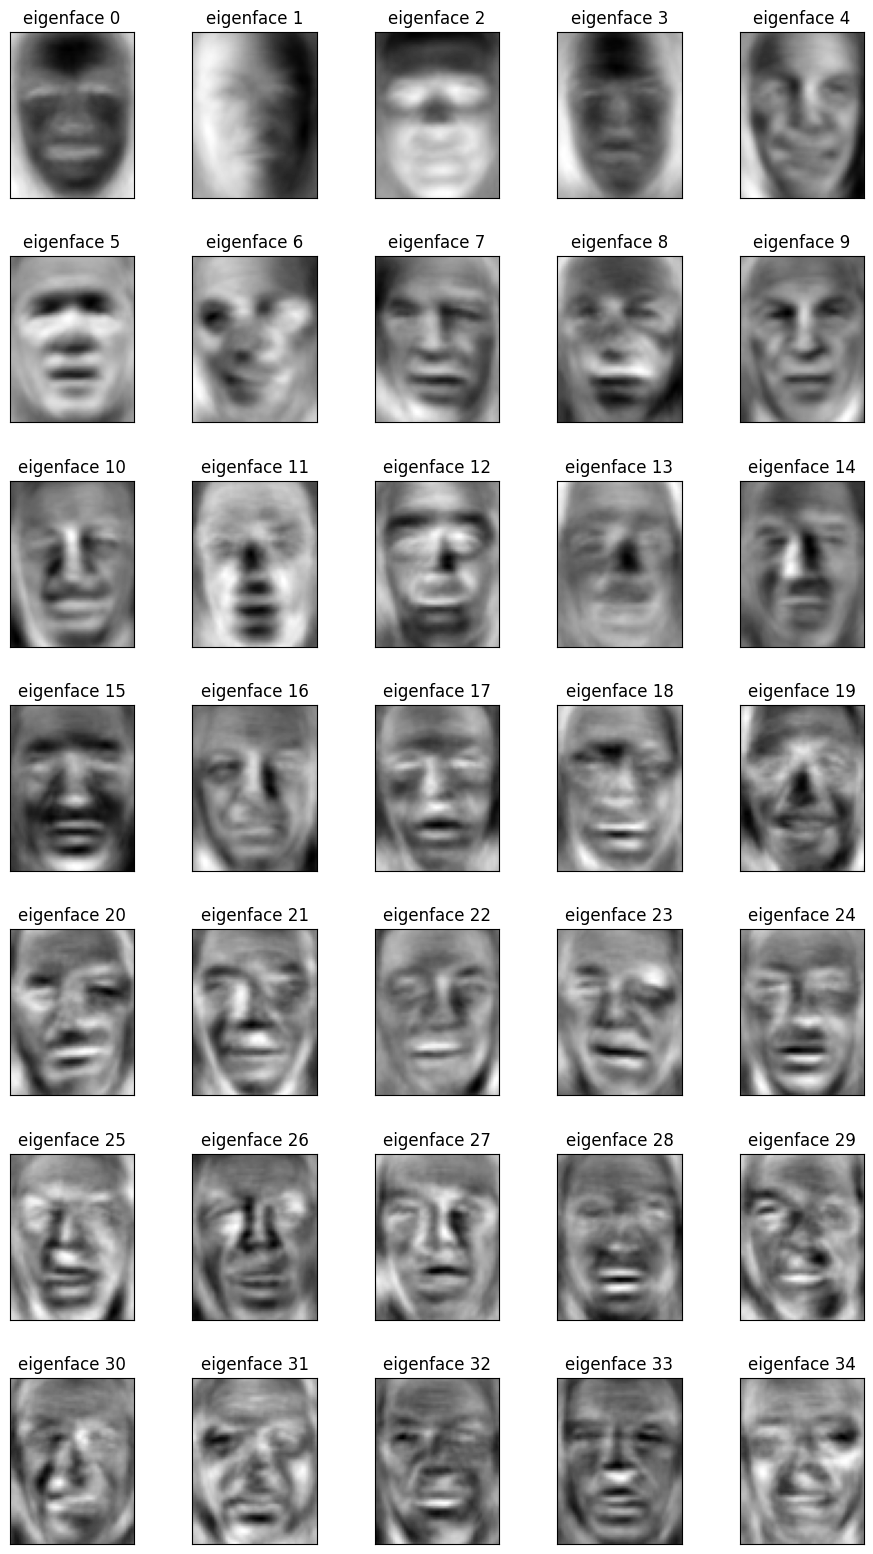

In [ ]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

# 1NN Algo #

In [ ]:
#Basic model
t0 = time()
y_pred = min_diff(X_test_pca, X_train_pca, y_train)
print("eigenfaces predictions made in: %0.3fs" % (time() - t0))

print('eigenfaces accuracy score: ', round(accuracy_score(y_test, y_pred), 3))


t0 = time()
y_pred = min_diff(X_test, X_train, y_train)
print("regular predictions made in: %0.3fs" % (time() - t0))

print('regular accuracy score: ', round(accuracy_score(y_test, y_pred), 3))

eigenfaces predictions made in: 0.918s
eigenfaces accuracy score:  0.713
regular predictions made in: 69.039s
regular accuracy score:  0.628


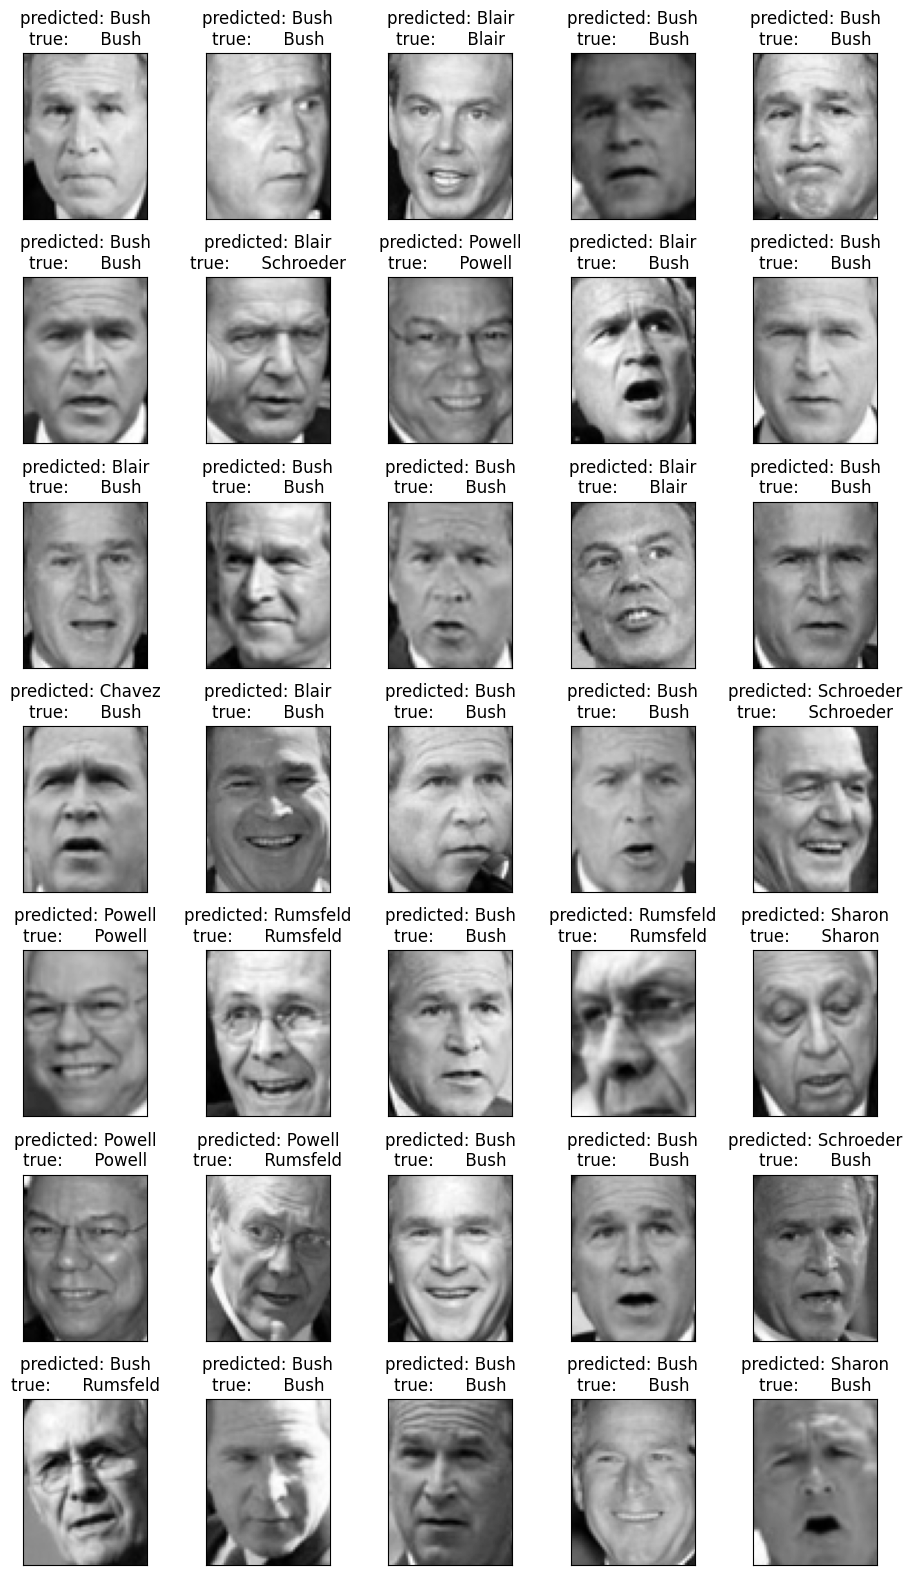

In [ ]:
y_pred = np.array(y_pred)

prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 2, random_state = 100)
distributions = dict(n_neighbors=list(range(1, 50)))

neigh = KNeighborsClassifier()

search = GridSearchCV(neigh, distributions, scoring = 'accuracy',  cv = cv)
result = search.fit(X_pca, y)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Best Score: 0.7367974806201549
Best Hyperparameters: {'n_neighbors': 5}


# Random Forest #

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 2, random_state = 90)
distributions = dict(max_depth=list(range(1,25)), n_estimators= list(range(1,100)))

rfc = RandomForestClassifier(random_state=7)

search = RandomizedSearchCV(rfc, distributions, n_iter = 150, scoring = 'accuracy', n_jobs = -1,  cv = cv, random_state = 12)
result = search.fit(X_pca, y)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Best Score: 0.6723625242248061
Best Hyperparameters: {'n_estimators': 87, 'max_depth': 16}


# Logistic Regression #

In [ ]:

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 2, random_state = 70)
param_grid = dict(multi_class=['ovr', 'multinomial'],  penalty=['l1', 'l2', 'elasticnet'], C=np.logspace(-4, 4, 20))

model = LogisticRegression(max_iter = 10000)
search = RandomizedSearchCV(model, param_grid, n_iter = 100, scoring = 'accuracy', n_jobs = -1, cv = cv, random_state = 20)
result = search.fit(X_pca, y)
print(round(result.best_score_, 3))
print('Best Hyperparameters: %s' % result.best_params_)

0.797
Best Hyperparameters: {'penalty': 'l2', 'multi_class': 'multinomial', 'C': 0.23357214690901212}


# SVM #

In [ ]:

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 2, random_state = 70)
param_grid = dict(gamma=['scale', 'auto'], degree= [1, 2, 3], C=list(np.arange(0.05, 1, .05)), kernel = ['linear', 'poly', 'rbf', 'sigmoid'])

clf = SVC()
search = RandomizedSearchCV(clf, param_grid, n_iter = 100, scoring = 'accuracy', n_jobs = -1, cv = cv, random_state = 589)
result = search.fit(X_pca, y)
print(round(result.best_score_, 3))
print('Best Hyperparameters: %s' % result.best_params_)

0.827
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 0.9500000000000001}


# Testing on outside preprocessed images #

(321, 321)


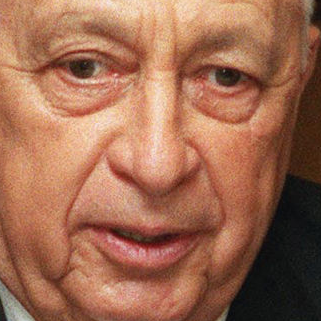

In [ ]:
b_test_path1 = '/content/drive/MyDrive/Northeastern/Spring 2023/DS 5230/images/Copy of ariel1.jpg'
b_test_path2 = '/content/drive/MyDrive/Northeastern/Spring 2023/DS 5230/images/Copy of colin5.jpg'

#img_modi = face_recognition.load_image_file('/content/drive/MyDrive/images/ariel1.jpg')
img_modi = face_recognition.load_image_file(b_test_path1)
#detect face
face = face_recognition.face_locations(img_modi)[0]
#crop image
#im = Image.open("/content/drive/MyDrive/images/ariel1.jpg")
im = Image.open(b_test_path1)
im_cropped = im.crop((face[3], face[0], face[1], face[2])) #left, upper, right, and lower
print(im_cropped.size)
im_cropped

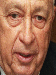

In [ ]:
im_np = np.asarray(im_cropped)

# Resize the image
my_image_resized = cv2.resize(im_np, (w, h))
PIL_image = Image.fromarray(my_image_resized).convert('RGB')
PIL_image

In [ ]:
inv_asp_ratio = h / w
width = im_cropped.size[0]
height = round(inv_asp_ratio * width)

# Define borders
center = (face[0] + face[2]) // 2, (face[1] + face[3]) // 2

print(center)

left = center[0] - round(width / 2)
upper = center[1] + round(height / 2)
right = center[0] + round(width / 2)
lower = center[1] - round(height / 2)

# Clamp borders to the image bounds
left = max(0, left)
upper = max(0, upper)
right = min(im.size[0], right)
lower = min(im.size[1], lower)

# Check if the borders are still valid after clamping
if left >= right or upper >= lower:
    print("Invalid crop borders after clamping")
else:
    # Crop borders
    im_cropped = im.crop((left, upper, right, lower))  # left, upper, right, and lower
    print(im_cropped.size)
    display(im_cropped)


'''inv_asp_ratio = h/w
width = im_cropped.size[0]
height = round(inv_asp_ratio*width)

print("h:", h, "w:", w, "inv_asp_ratio:", inv_asp_ratio, "height:", height)


#define borders
center = (face[3]*face[1])//2, (face[0]+face[2])//2


left = center[0] - round(width/2)
upper = center[1] + round(height/2)
right = center[0] + round(width/2)
lower = center[1] - round(height/2)



#crop borders
im_cropped = im.crop((left, upper, right, lower)) #left, upper, right, and lower
print(im_cropped.size)
im_cropped'''


(437, 437)
Invalid crop borders after clamping


'inv_asp_ratio = h/w\nwidth = im_cropped.size[0]\nheight = round(inv_asp_ratio*width)\n\nprint("h:", h, "w:", w, "inv_asp_ratio:", inv_asp_ratio, "height:", height)\n\n\n#define borders\ncenter = (face[3]*face[1])//2, (face[0]+face[2])//2\n\n\nleft = center[0] - round(width/2)\nupper = center[1] + round(height/2)\nright = center[0] + round(width/2)\nlower = center[1] - round(height/2)\n\n\n\n#crop borders\nim_cropped = im.crop((left, upper, right, lower)) #left, upper, right, and lower\nprint(im_cropped.size)\nim_cropped'

Processing Copy of ariel2.jpg:
Processing Copy of colin3.jpg:
Processing Copy of colin5.jpg:
Processing Copy of ariel4.jpg:
Processing Copy of ariel1.jpg:
Processing Copy of ariel3.jpg:
Processing Copy of colin4.jpg:
Processing Copy of ariel5.jpg:
Processing Copy of colin1.jpg:
Processing Copy of colin2.jpg:
Processing Copy of donald3.jpg:
Processing Copy of george1.jpg:
Processing Copy of donald2.jpg:
Processing Copy of george5.jpg:
Processing Copy of donald5.jpg:
Processing Copy of donald4.jpg:
Processing Copy of donald1.jpg:
Processing Copy of george4.jpg:
Processing Copy of george3.jpg:
Processing Copy of george2.jpg:
Processing Copy of gerard5.jpg:
Processing Copy of gerard2.jpg:
Processing Copy of gerard4.jpg:
Processing Copy of hugo2.jpg:
Processing Copy of hugo1.jpg:
Processing Copy of gerard1.jpg:
Processing Copy of gerard3.jpg:
Processing Copy of tony4.jpg:
Processing Copy of tony3.jpg:
Processing Copy of hugo4.jpg:
Processing Copy of tony2.jpg:
Processing Copy of hugo5.jpg:


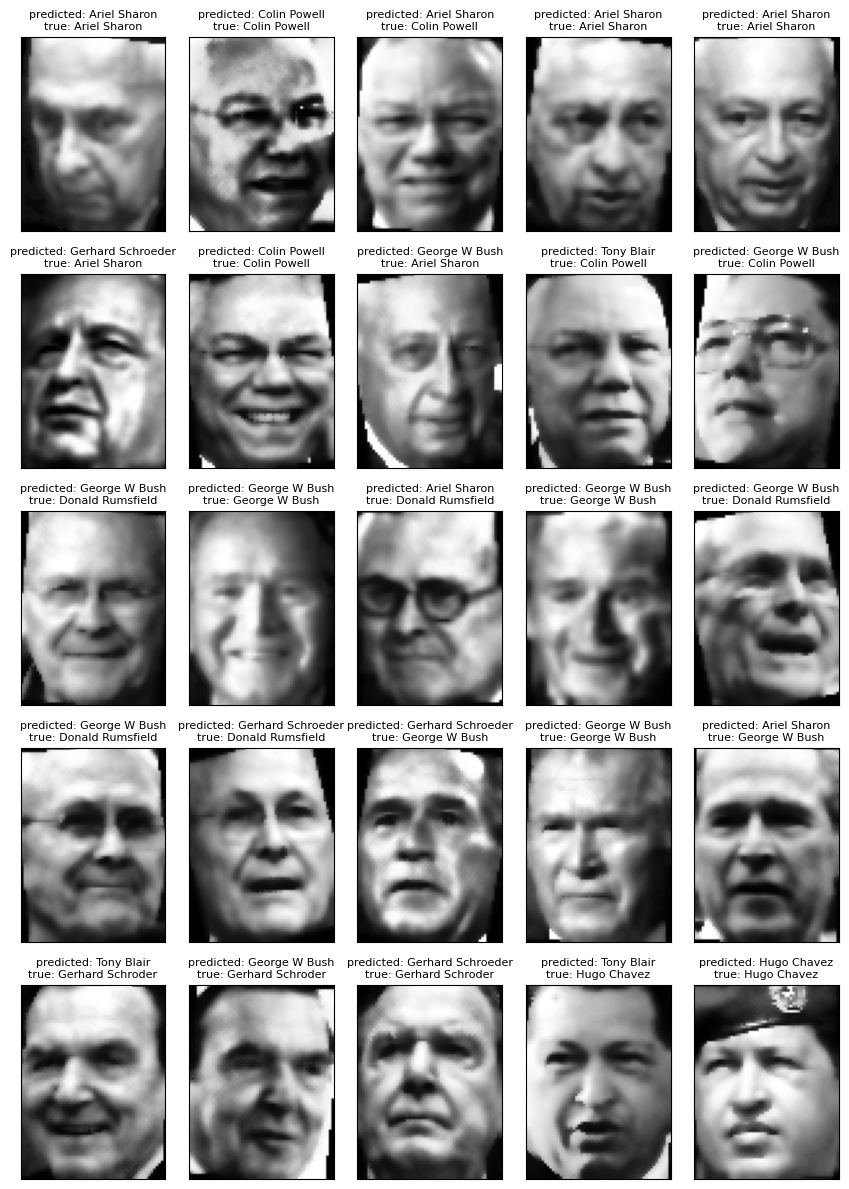

In [ ]:
# Call the predict_my_photo function with the path to your photo in Google Drive
my_photo_path = '/content/drive/MyDrive/images'
my_photos_folder_path = '/content/drive/MyDrive/Northeastern/Spring 2023/DS 5230/images'
predict_all_photos(my_photos_folder_path)





In [1]:
# testing logistic regression

log_model = LogisticRegression(penalty = 'l2', multi_class ='ovr', C=0.08858667904100823, max_iter = 10000).fit(X_pca, y)
svm_model = SVC(kernel='rbf', gamma='scale', degree=2, C=0.95).fit(X_pca, y)
# Call the predict_my_photo function with the path to your photo in Google Drive
my_photo_path = '/content/drive/MyDrive/images'
my_photos_folder_path = '/content/drive/MyDrive/Northeastern/Spring 2023/DS 5230/images'
X_val, y_val, y_pred, tracked = ml_predict_all_photos(my_photos_folder_path, log_model)


NameError: ignored

In [ ]:
pd.Series(y_val).value_counts()

Ariel Sharon        5
Colin Powell        5
Donald Rumsfield    5
George W Bush       5
Gerhard Schroder    5
Hugo Chavez         5
Tony Blair          5
dtype: int64

Processing Copy of ariel2.jpg:
Processing Copy of colin3.jpg:
Processing Copy of colin5.jpg:
Processing Copy of ariel4.jpg:
Processing Copy of ariel1.jpg:
Processing Copy of ariel3.jpg:
Processing Copy of colin4.jpg:
Processing Copy of ariel5.jpg:
Processing Copy of colin1.jpg:
Processing Copy of colin2.jpg:
Processing Copy of donald3.jpg:
Processing Copy of george1.jpg:
Processing Copy of donald2.jpg:
Processing Copy of george5.jpg:
Processing Copy of donald5.jpg:
Processing Copy of donald4.jpg:
Processing Copy of donald1.jpg:
Processing Copy of george4.jpg:
Processing Copy of george3.jpg:
Processing Copy of george2.jpg:
Processing Copy of gerard5.jpg:
Processing Copy of gerard2.jpg:
Processing Copy of gerard4.jpg:
Processing Copy of hugo2.jpg:
Processing Copy of hugo1.jpg:
Processing Copy of gerard1.jpg:
Processing Copy of gerard3.jpg:
Processing Copy of tony4.jpg:
Processing Copy of tony3.jpg:
Processing Copy of hugo4.jpg:
Processing Copy of tony2.jpg:
Processing Copy of hugo5.jpg:


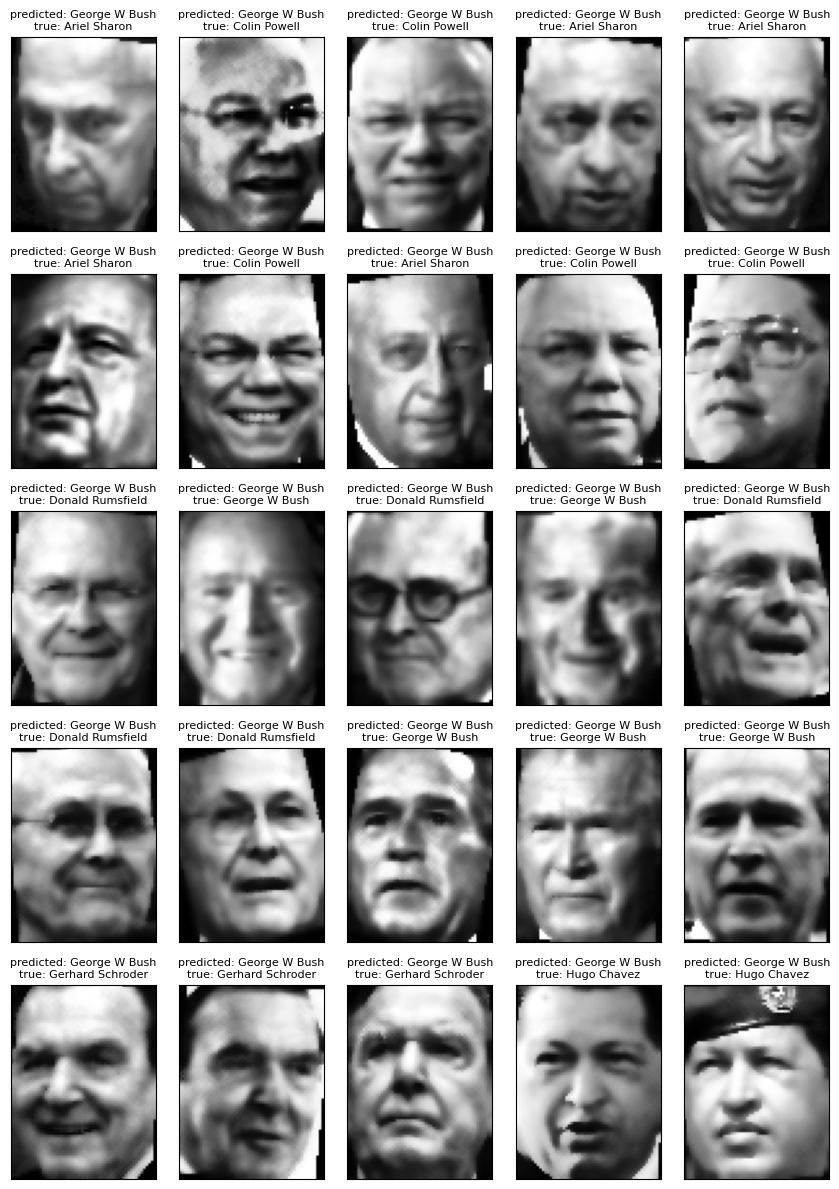

In [ ]:
#testing svm
X_val, y_val, y_pred, tracked = ml_predict_all_photos(my_photos_folder_path, svm_model)

Processing Copy of ariel2.jpg:
Processing Copy of colin3.jpg:
Processing Copy of colin5.jpg:
Processing Copy of ariel4.jpg:
Processing Copy of ariel1.jpg:
Processing Copy of ariel3.jpg:
Processing Copy of colin4.jpg:
Processing Copy of ariel5.jpg:
Processing Copy of colin1.jpg:
Processing Copy of colin2.jpg:
Processing Copy of donald3.jpg:
Processing Copy of george1.jpg:
Processing Copy of donald2.jpg:
Processing Copy of george5.jpg:
Processing Copy of donald5.jpg:
Processing Copy of donald4.jpg:
Processing Copy of donald1.jpg:
Processing Copy of george4.jpg:
Processing Copy of george3.jpg:
Processing Copy of george2.jpg:
Processing Copy of gerard5.jpg:
Processing Copy of gerard2.jpg:
Processing Copy of gerard4.jpg:
Processing Copy of hugo2.jpg:
Processing Copy of hugo1.jpg:
Processing Copy of gerard1.jpg:
Processing Copy of gerard3.jpg:
Processing Copy of tony4.jpg:
Processing Copy of tony3.jpg:
Processing Copy of hugo4.jpg:
Processing Copy of tony2.jpg:
Processing Copy of hugo5.jpg:


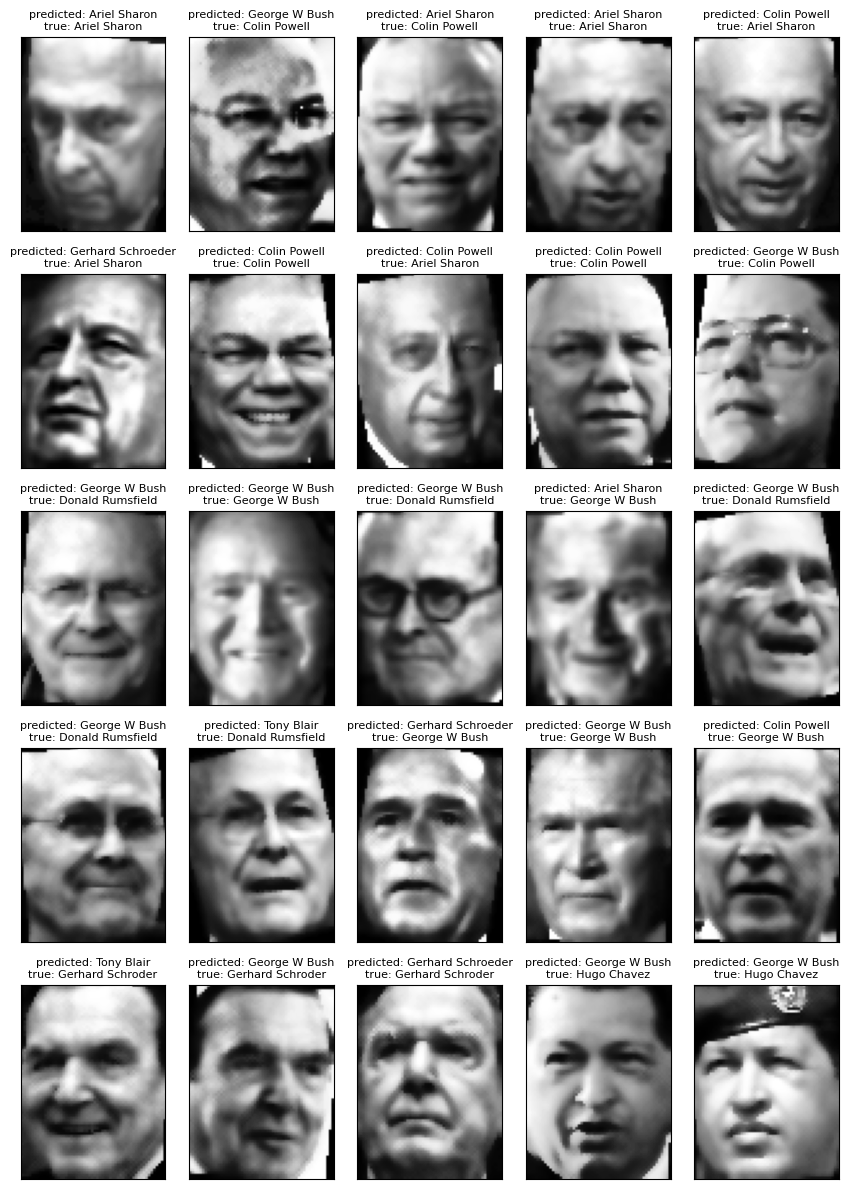

In [ ]:
#testing knn
neigh_model = KNeighborsClassifier(n_neighbors = 8).fit(X_pca, y)
X_val, y_val, y_pred, tracked = ml_predict_all_photos(my_photos_folder_path, neigh_model)